# DISCERN Mapping Tutorial 

DiSCERN - Deep Single Cell Expression ReconstructioN can be used to reconstruct missing expression information using a reference data set.

In this tutorial, we'll apply DISCERN on five single cell RNAseq data sets to reconstruct expression information. We'll apply the reconstruction with one trained model but two reference data sets.
The data set is a human pancreatic islet cell dataset coming from different studies. The cells were sequenced using four different sequencing technologies CelSeq (GSE81076), CelSeq2 (GSE85241), Fluidigm C1 (GSE86469) and SMART-Seq2 (E-MTAB-5061).
It available through the SeuratData package. 

The tutorial consists of four parts:
1. Download
2. Data preprocessing
3. DiSCERN training and reconstruction
4. Comparison of number of counts per cell

In part 1 the example expression data and cell type information is downloaded.
In part 2 the preprocessing pipeline provided with DiSCERN is applied. This includes log-scaling and scaling of the data.
In part 3 DiSCERN is trained and the applied on the data sets. Here we reconstruct the expression using the smartseq2 (higher number of counts) and the indrop (lower number of counts) batch as reference.
Finally, we show a UMAP for both reconstructions and analyze how the number of counts changes by the choice of reference batch.

In [1]:
import json
import pathlib

import discern
import matplotlib.pyplot as plt
import matplotlib as mpl
import scanpy as sc
import pandas as pd

import tensorflow as tf
import numpy as np
tf.random.set_seed(42)
np.random.seed(42)

If discern is not available try installing it with:
```python
 pip install -U discern-reconstruction
```

## Download example data

This part is for downloading the example data. If you have already downloaded this data or plan to use your own data, you can skip this tutorial without any issues.

In [2]:
import requests

In [3]:
def download( data_path="data"):
    data_path = pathlib.Path(data_path)
    data_path.mkdir(exist_ok=True)
    pancreas_data = data_path.joinpath("panc8.h5ad")
    if not pancreas_data.exists():
        r = requests.get(
            "https://github.com/imsb-uke/discern/releases/download/v0.1.1/panc8.h5ad",
            allow_redirects=True,
        )
        pancreas_data.write_bytes(r.content)

In [4]:
download()

## Loading and preprocessing

DiSCERN requires the training data in a format build upon [anndata.AnnData](https://anndata.readthedocs.io/en/latest/#) similar to [scanpy](https://scanpy.readthedocs.io/en/stable/).

Data set preparation requires a custom preprocessing involving library-size normalization, log-scaling and mean-variance-centering.
The preprocessing pipeline closely follows [Zheng et al. (2017)](https://www.nature.com/articles/ncomms14049).

The preprocessing pipeline is implemented in [`discern.WAERecipe`](https://discern.readthedocs.io/en/latest/api.html#discern.preprocessing.WAERecipe).

In [5]:
from discern import WAERecipe

Default parameters for this preprocessing and model training can be found in [`parameters.json`](https://github.com/imsb-uke/discern/blob/main/parameters.json). These parameters should work for most applications.

In [6]:
default_parameter = json.loads(pathlib.Path("parameters.json").read_bytes())[
    "experiments"
]["default_experiment"]

In this tutorial we used the dummy data downloaded by `download()` function above.
The data should be located in `data` directory, but a also custom data sets can be used.

The data sets can easily be read using [`sc.read`](https://scanpy.readthedocs.io/en/latest/generated/scanpy.read.html)

In [7]:
pancreas = sc.read("data/panc8.h5ad")

In [8]:
pancreas.X = pancreas.X.toarray() # Converting sparse expression data to a dense representation

The complete data set is now split into a a dictionary containing each batch individually. 
This can be directly be used as an input for DISCERN.

In [9]:
datasets = {batchname: pancreas[pancreas.obs["batch"] == batchname] for batchname in pancreas.obs["batch"].cat.categories}
datasets

{'celseq': View of AnnData object with n_obs × n_vars = 1004 × 34363
     obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'tech', 'replicate', 'assigned_cluster', 'celltype', 'dataset', 'batch',
 'celseq2': View of AnnData object with n_obs × n_vars = 2285 × 34363
     obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'tech', 'replicate', 'assigned_cluster', 'celltype', 'dataset', 'batch',
 'fluidigmc1': View of AnnData object with n_obs × n_vars = 638 × 34363
     obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'tech', 'replicate', 'assigned_cluster', 'celltype', 'dataset', 'batch',
 'indrop': View of AnnData object with n_obs × n_vars = 8569 × 34363
     obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'tech', 'replicate', 'assigned_cluster', 'celltype', 'dataset', 'batch',
 'smartseq2': View of AnnData object with n_obs × n_vars = 2394 × 34363
     obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'tech', 'replicate', 'assigned_cluster', 'celltype', 'dataset', 'batch'}

[`discern.WAERecipe`](https://discern.readthedocs.io/en/latest/api.html#discern.preprocessing.WAERecipe) requires the parameters as found in the `parameters.json` and 
two or more input data sets as dictionary.
The dictionary keys will be used as batch labels later for reconstruction.

In [10]:
recipe = WAERecipe(
    params=default_parameter, inputs=datasets
)

Trying to set attribute `.obs` of view, copying.
Overwriting `dataset` column with filename, if you need this column, rename it beforehand.
Trying to set attribute `.obs` of view, copying.
Overwriting `dataset` column with filename, if you need this column, rename it beforehand.
Trying to set attribute `.obs` of view, copying.
Overwriting `dataset` column with filename, if you need this column, rename it beforehand.
Trying to set attribute `.obs` of view, copying.
Overwriting `dataset` column with filename, if you need this column, rename it beforehand.
Trying to set attribute `.obs` of view, copying.
Overwriting `dataset` column with filename, if you need this column, rename it beforehand.


After initializing the `WAERecipe` you can run the pipeline by calling and accessing the processed data using the `.sc_raw` attribute.
This will be used as input for DiSCERN model training. 

In [11]:
preprocessed_results = recipe().sc_raw

## DiSCERN reconstruction

### Create DiSCERN model

The discern model is implemented in the [`DISCERN`](https://discern.readthedocs.io/en/latest/api.html#discern.estimators.batch_integration.DISCERN) class and can be initialized directly from the default parameters, read from the `parameters.json` file above.

In [12]:
from discern import DISCERN

In [13]:
model = DISCERN.from_json(default_parameter)

As DISCERN is build on the [Tensorflow](https://www.tensorflow.org/) backend, the deep learning model needs to be initalized.
This can be achieved using the `build_model` function. It requires 3 arguments to to determine the input and output shapes:
- `n_nenes` which determines the input and output shape of the gene expression matrix.
- `n_labels` which indicates the number of datasets.
- `scale` which is a loss scaling factor, based on the total number of training samples, it is available in `preprocessed_results.config["total_train_count"]`.

In [14]:
model.build_model(
    n_genes=preprocessed_results.var_names.size,
    n_labels=preprocessed_results.obs.batch.nunique(),
    scale=preprocessed_results.config["total_train_count"],
)

### Train DiSCERN

The DISCERN model learns the gene regulatory network using the gene expression data. This is called "training".

To do so the data set is splitted into parts of smaller size, called mini-batches. 
The size of such a part needs to be set using the `batch_size` attribute. Usually 192 is a good choice but a higher or lower size can be choosen depending on the computational power.

In [15]:
preprocessed_results.batch_size = 192

The training can be performed using the `training` method.
 
The number of training steps (`max_steps`) is data set dependent and a higher value increase the running time, but up to a point, also the reconstruction quality.
Usually something around 30-50 is a good choice. Here it runs with 20 steps for computational reasons. 

The Commandline - API contains a more advanced method to determine the number of steps automatically (if defined in the `early_stopping` section of the `parameters.json` file).

In [16]:
losses = model.training(inputdata=preprocessed_results, max_steps=20)

Epoch 1/20
Epoch 1/20
69/69 - 80s - loss: 8141.1242 - decoder_counts_loss: 0.4155 - decoder_dropouts_loss: 0.1739 - mmdpp_loss: 0.1133 - sigma_regularization_loss: 480.8722 - val_loss: 5772.9065 - val_decoder_counts_loss: 0.3556 - val_decoder_dropouts_loss: 0.0024 - val_mmdpp_loss: 0.2761 - val_sigma_regularization_loss: 481.0160
Epoch 2/20
Epoch 1/20
69/69 - 74s - loss: 5434.2762 - decoder_counts_loss: 0.3589 - decoder_dropouts_loss: 0.0012 - mmdpp_loss: 0.0259 - sigma_regularization_loss: 480.7760 - val_loss: 5404.0769 - val_decoder_counts_loss: 0.3400 - val_decoder_dropouts_loss: 5.9408e-04 - val_mmdpp_loss: 0.1987 - val_sigma_regularization_loss: 480.6467
Epoch 3/20
Epoch 1/20
69/69 - 76s - loss: 5296.9127 - decoder_counts_loss: 0.3509 - decoder_dropouts_loss: 4.3598e-04 - mmdpp_loss: 0.0189 - sigma_regularization_loss: 481.9139 - val_loss: 5316.8276 - val_decoder_counts_loss: 0.3360 - val_decoder_dropouts_loss: 3.5654e-04 - val_mmdpp_loss: 0.1825 - val_sigma_regularization_loss: 4

The model losses, indicating the quality of the learned information, can be visualized from the resulting `losses` object. 

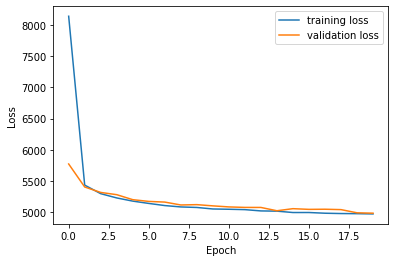

In [17]:
plt.plot(losses.epoch, losses.history["loss"], label="training loss")
plt.plot(losses.epoch, losses.history["val_loss"], label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Reconstruction with DiSCERN

Finally the preprocessed data can be reconstructed with the trained model.

Therefore the reference data set needs to be mentioned using a column available in `preprocessed_results.obs`.

In the usual case this column is `batch` and the reference batch is supplied by the `column_value` argment.

We can reconstruct the expression data using the `smartseq2` batch as a reference ...

In [18]:
reconstructed_data_smartseq2 = model.reconstruct(
    input_data=preprocessed_results,
    column="batch",
    column_value="smartseq2",
)

... and the `indrop` batch as a reference. 
Both will lead different results since the expression values are adjusted similar to `smartseq2` and the `indrop` batch individually. Both reconstructions yield an independent data set which contains all cells of all batches. 

In [19]:
reconstructed_data_indrop = model.reconstruct(
    input_data=preprocessed_results,
    column="batch",
    column_value="indrop",
)

## Visualization of reconstructed results

Finally the data can be analyzed with a standard pipeline, for example for data visulization.

Thus, we perform PCA and UMAP computation as implemented in `scanpy`. 
See [here](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) fore more information. 

In [20]:
sc.pp.pca(preprocessed_results)
sc.pp.pca(reconstructed_data_smartseq2)
sc.pp.pca(reconstructed_data_indrop)

In [21]:
sc.pp.neighbors(preprocessed_results)
sc.pp.neighbors(reconstructed_data_smartseq2)
sc.pp.neighbors(reconstructed_data_indrop)

In [22]:
sc.tl.umap(preprocessed_results)
sc.tl.umap(reconstructed_data_smartseq2)
sc.tl.umap(reconstructed_data_indrop)

... storing 'orig.ident' as categorical
... storing 'tech' as categorical
... storing 'replicate' as categorical
... storing 'assigned_cluster' as categorical
... storing 'dataset' as categorical


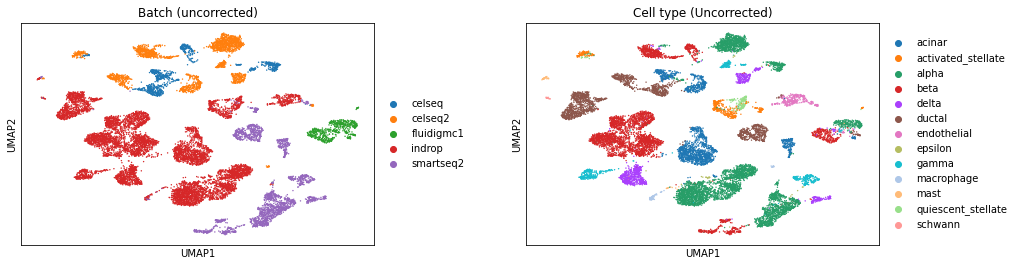

... storing 'orig.ident' as categorical
... storing 'tech' as categorical
... storing 'replicate' as categorical
... storing 'assigned_cluster' as categorical
... storing 'dataset' as categorical


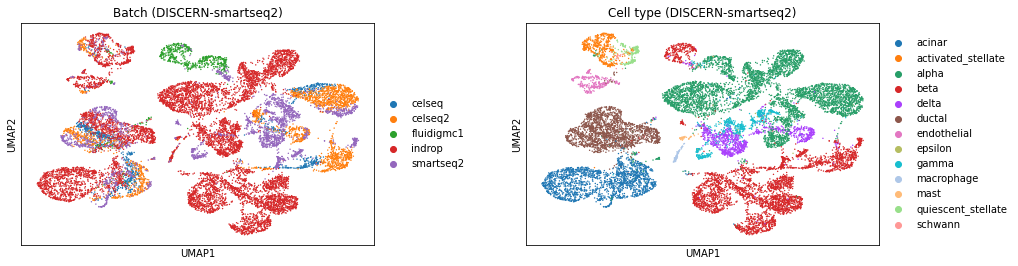

... storing 'orig.ident' as categorical
... storing 'tech' as categorical
... storing 'replicate' as categorical
... storing 'assigned_cluster' as categorical
... storing 'dataset' as categorical


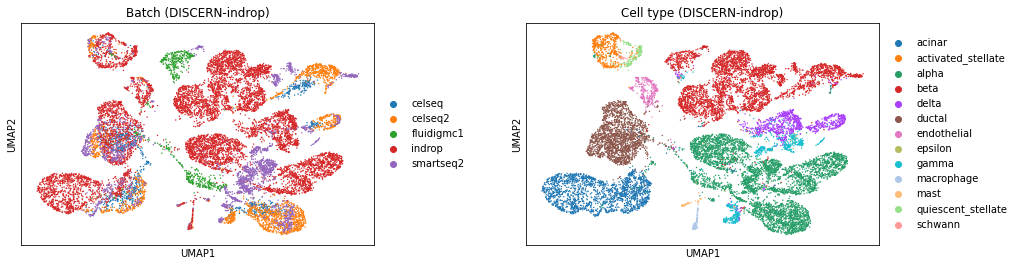

In [23]:
sc.pl.umap(
    preprocessed_results,
    color=["batch", "celltype"],
    wspace=0.3,
    title=["Batch (uncorrected)", "Cell type (Uncorrected)"],
)
sc.pl.umap(
    reconstructed_data_smartseq2,
    color=["batch", "celltype"],
    wspace=0.3,
    title=["Batch (DISCERN-smartseq2)", "Cell type (DISCERN-smartseq2)"],
)
sc.pl.umap(
    reconstructed_data_indrop,
    color=["batch", "celltype"],
    wspace=0.3,
    title=["Batch (DISCERN-indrop)", "Cell type (DISCERN-indrop)"],
)

Next, we extract the number of counts (sum of gene expression per cell) from the preprocessed data and the two reconstructed data sets.

Since the preprocessed dataset is mean-variance-scaled during preprocessing, it needs to be rescaled. The DISCERN reconstructed data sets are automatically rescaled.

In [24]:
n_counts = pd.DataFrame({"Uncorrected":(preprocessed_results.to_df() * preprocessed_results.var["var_scaling"] + preprocessed_results.var["mean_scaling"]).sum(axis=1),
"Reconstructed (smartseq2)":reconstructed_data_smartseq2.to_df().sum(axis=1),
 "Reconstructed (indrop)":reconstructed_data_indrop.to_df().sum(axis=1),
})

Since we're interested mainly in the reconstruction, we'll subset the data to only `smartseq2` and `indrop` data.

In [25]:
n_counts = n_counts.loc[preprocessed_results.obs.query("batch == ('smartseq2','indrop')").index]

To check the distribution of the number of counts we can plot histograms for reconstructed and uncorrected data.
Here one can see, that reconstructed data with smartseq2 reference shows a higher number of counts, while for the `indrop` based reconstruction it is similar to the uncorrected data.
The histogramm of the uncorrected data is highly biased towards the `indrop` batch, since it is much bigger that the `smartseq2` batch (8569 cells compared to 2394 cells).

In [26]:
colors = {x: mpl.cm.get_cmap("tab20")([i])[0] for i, x in enumerate(["Uncorrected","Uncorrected (indrop)","Uncorrected (smartseq2)","Reconstructed (smartseq2)","Reconstructed (indrop)"])}

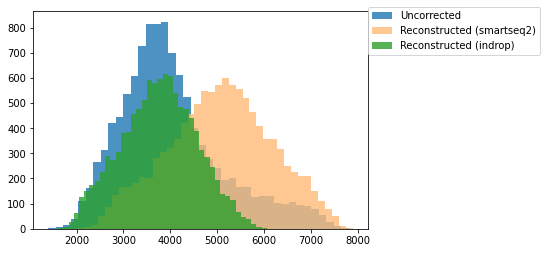

In [27]:
for col in n_counts.columns:
    plt.hist(n_counts[col], label=col, alpha=0.8, bins=40, color=colors[col][:-1])
plt.legend(loc=(1,0.8))
plt.show()

For the uncorrected data, there are two peaks visible, one at around 3500 counts and one small peak at around 5000-6000 counts.
We'll investigate this in more detail by dividing the uncorrected data by batch, to get a better picture on the count distribution of indivdual batches.

In [28]:
n_counts["Uncorrected (smartseq2)"] = n_counts["Uncorrected"]
n_counts["Uncorrected (indrop)"] = n_counts["Uncorrected"]

In [29]:
n_counts.loc[preprocessed_results.obs.query("batch == 'smartseq2'").index,"Uncorrected (indrop)"] = np.nan
n_counts.loc[preprocessed_results.obs.query("batch == 'indrop'").index,"Uncorrected (smartseq2)"] = np.nan

DISCERN adjusts the expression values to `indrop` level when using the `indrop` batch as a reference and to `smartseq2` level. One can see that the uncorrected expression values per batch overlap nicely with the predicted expression values after reconstruction to the specific reference batch. 

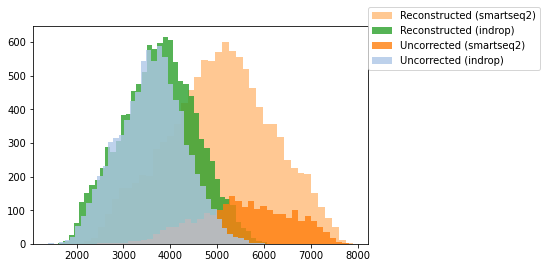

In [30]:
for col in n_counts.drop(columns=["Uncorrected"]).columns:
    plt.hist(n_counts[col], label=col, alpha=0.8, bins=40, color=colors[col][:-1])
plt.legend(loc=(1,0.8))
plt.show()